In [3]:
# Reload all modules at every code execution
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from thenetflixstory.data_processing import load_netflixdata

df_netflix = load_netflixdata()

In [4]:
df_netflix.head(1)

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in,duration_minutes,seasons,rating_description,rating_age,country_clean,ISO3_country,genres_list
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,2021-09-25,2020,PG-13,90 min,Documentaries,90,<NA>,"Ab 13 Jahren, elterliche Begleitung empfohlen",13.0,United States,USA,[Documentaries]


## Pre-Checks

It looks like the seasons are only used for TV-Shows and duration_minutes for Movies but lets verify that properly

In [2]:
df_netflix["duration_unit"] = df_netflix["duration"].apply(
    lambda x: "min" if "min" in x else "season" if "Season" in x else "unknown"
)
print(df_netflix.groupby(["type", "duration_unit"]).size())


type     duration_unit
Movie    min              6126
TV Show  season           2664
dtype: int64


## Add features

### Extract Genre (Explode and OneHot)
listed_in is a multi-label-list for genres.

In [4]:
df_formap = (
    df_netflix[~df_netflix['ISO3_country'].isna()] # Remove Moview without Country
    .groupby(['release_year','ISO3_country'],as_index=False)['title']
    .count()
)

# Viusualisierungskonzepte

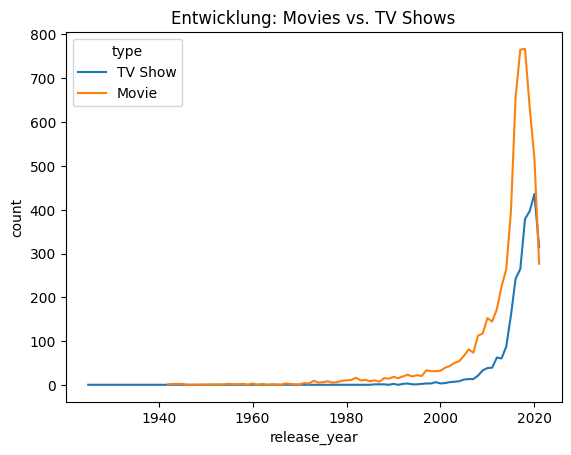

In [3]:
df_trend = (
    df_netflix
    .groupby(['release_year', 'type'])
    .size()
    .reset_index(name='count')
)

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    data=df_trend,
    x='release_year',
    y='count',
    hue='type'
)

plt.title("Entwicklung: Movies vs. TV Shows")
plt.show()


- The biggest influence in the Netflix-Universe comes with no doubts from the United States.
- The most contributing 

In [45]:
import pandas as pd
import plotly.graph_objects as go

# ======================================================================
#  Helpers
# ======================================================================

def colorize_label(label, highlights):
    """Generate an HTML-colored Plotly label."""
    return (
        f"<span style='color:black;font-weight:600'>{label}</span>"
        if label in highlights else
        f"<span style='color:grey'>{label}</span>"
    )


def build_flows(df, flow_specs):
    """
    Build grouped flow-dataframes for any sequence of (source, target) pairs.
    Returns: list of DataFrames.
    """
    flows = []
    for src, tgt in flow_specs:
        f = df.groupby([src, tgt]).size().reset_index(name="value")
        flows.append(f)
    return flows


def collect_unique_nodes(flows):
    """Collect unique node names from all flow dataframes."""
    nodes = []
    for f in flows:
        nodes.extend(f.iloc[:, 0].unique())
        nodes.extend(f.iloc[:, 1].unique())
    return list(dict.fromkeys(nodes))  # preserves order


def map_links(flows, node_index):
    """Convert all flows into unified source/target/value lists."""
    sources, targets, values = [], [], []
    for f in flows:
        s = f.iloc[:, 0].map(node_index)
        t = f.iloc[:, 1].map(node_index)
        v = f["value"]
        sources.extend(s)
        targets.extend(t)
        values.extend(v)
    return sources, targets, values


# ======================================================================
#  Preprocessing
# ======================================================================

df = df_netflix.copy()
#df = df.query('country == "Honduras"')
df["decade"] = (df["release_year"] // 10) * 10
df = df.explode("genres_list").rename(columns={"genres_list": "genre"})

# Countries aggregieren
threshold = 1000
country_counts = df["country"].value_counts()
rare_countries = country_counts[country_counts < threshold].index
df["country"] = df["country"].where(~df["country"].isin(rare_countries),
                                    f"{len(rare_countries)} other countries")

# ======================================================================
#  Definition der Sankey-Ebenen (→ nur hier anpassen)
# ======================================================================

flow_specs = [
    ("country", "genre"),
    ("genre", "type"),
    ("type", "decade"),
]

# ======================================================================
#  Flow-Building
# ======================================================================

flows = build_flows(df, flow_specs)

# decade zu String (falls vorkommend)
for f in flows:
    if "decade" in f.columns:
        f["decade"] = f["decade"].astype(str)

# Nodes + Indices
nodes = collect_unique_nodes(flows)
node_index = {n: i for i, n in enumerate(nodes)}

# Gesamte Links
source, target, value = map_links(flows, node_index)

# ======================================================================
#  Color Mapping
# ======================================================================

paired_colors = {
    "International Movies": "rgba(31,119,180,0.8)", "International TV Shows": "rgba(31,119,180,0.8)",
    "Dramas": "rgba(255,127,14,0.8)",               "TV Dramas": "rgba(255,127,14,0.8)",
    "Comedies": "rgba(44,160,44,0.8)",              "TV Comedies": "rgba(44,160,44,0.8)",
    "Documentaries": "rgba(214,39,40,0.8)",         "Docuseries": "rgba(214,39,40,0.8)",
    "Action & Adventure": "rgba(148,103,189,0.8)",  "Crime TV Shows": "rgba(148,103,189,0.8)",
    "Children & Family Movies": "rgba(140,86,75,0.8)",
    "Kids' TV": "rgba(140,86,75,0.8)",
    "United States": "black",
    "2010": "lightgreen"
}

default_color = "rgba(160,160,160,0.4)"

# Node-Farben
node_colors = [paired_colors.get(n, default_color) for n in nodes]

# Linkfarbe = Farbe der SOURCE
link_colors = [node_colors[s] for s in source]

# Sonderfall: Links → 2010 = grün
if "2010" in node_index:
    tgt_2010 = node_index["2010"]
    for i, t in enumerate(target):
        if t == tgt_2010:
            link_colors[i] = "lightgreen"

# ======================================================================
#  Labels
# ======================================================================

highlight_nodes = set(paired_colors.keys())
labels_html = [colorize_label(n, highlight_nodes) for n in nodes]

# ======================================================================
#  Final Plot
# ======================================================================

fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=labels_html,
        pad=20,
        thickness=15,
        color=node_colors,
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors,
    )
)])

fig.update_layout(
    title_text="The Netflix-Universe",
    width=1000,
    height=800,
    font_size=14,
)

# Layer-Positionen (x zwischen 0 und 1)
layer_x = [0.05, 0.5, 1.0]  # Country, Genre, Type → Decade

layer_titles = [
    "Countries Influence",
    "Most Popular Genres",
    "Production Over Time"
]

for x, title in zip(layer_x, layer_titles):
    fig.add_annotation(
        x=x, y=1.05,   # y > 1, oberhalb des Plots
        xref="paper", yref="paper",
        text=f"<b>{title}</b>",
        showarrow=False,
        font=dict(size=16)
    )

fig.show()


In [41]:
import pandas as pd
import plotly.graph_objects as go

# ======================================================================
#  Helpers
# ======================================================================

def colorize_label(label, highlights):
    """Generate an HTML-colored Plotly label."""
    return (
        f"<span style='color:black;font-weight:600'>{label}</span>"
        if label in highlights else
        f"<span style='color:grey'>{label}</span>"
    )


def build_flows(df, flow_specs):
    """
    Build grouped flow-dataframes for any sequence of (source, target) pairs.
    Returns: list of DataFrames.
    """
    flows = []
    for src, tgt in flow_specs:
        f = df.groupby([src, tgt]).size().reset_index(name="value")
        flows.append(f)
    return flows


def collect_unique_nodes(flows):
    """Collect unique node names from all flow dataframes."""
    nodes = []
    for f in flows:
        nodes.extend(f.iloc[:, 0].unique())
        nodes.extend(f.iloc[:, 1].unique())
    return list(dict.fromkeys(nodes))  # preserves order


def map_links(flows, node_index):
    """Convert all flows into unified source/target/value lists."""
    sources, targets, values = [], [], []
    for f in flows:
        s = f.iloc[:, 0].map(node_index)
        t = f.iloc[:, 1].map(node_index)
        v = f["value"]
        sources.extend(s)
        targets.extend(t)
        values.extend(v)
    return sources, targets, values


# ======================================================================
#  Preprocessing
# ======================================================================

df = df_netflix.copy()
df["decade"] = (df["release_year"] // 10) * 10
df = df.explode("genres_list").rename(columns={"genres_list": "genre"})

# Countries aggregieren
threshold = 1000
country_counts = df["country"].value_counts()
rare_countries = country_counts[country_counts < threshold].index
df["country"] = df["country"].where(~df["country"].isin(rare_countries),
                                    f"{len(rare_countries)} other countries")

# ======================================================================
#  Definition der Sankey-Ebenen (→ nur hier anpassen)
# ======================================================================

flow_specs = [
    ("genre", "country"),
   # ("genre", "type"),
   # ("type", "decade"),
]

# ======================================================================
#  Flow-Building
# ======================================================================

flows = build_flows(df, flow_specs)

# decade zu String (falls vorkommend)
for f in flows:
    if "decade" in f.columns:
        f["decade"] = f["decade"].astype(str)

# Nodes + Indices
nodes = collect_unique_nodes(flows)
node_index = {n: i for i, n in enumerate(nodes)}

# Gesamte Links
source, target, value = map_links(flows, node_index)

# ======================================================================
#  Color Mapping
# ======================================================================

paired_colors = {
    "International Movies": "rgba(31,119,180,0.8)", "International TV Shows": "rgba(31,119,180,0.8)",
    "Dramas": "rgba(255,127,14,0.8)",               "TV Dramas": "rgba(255,127,14,0.8)",
    "Comedies": "rgba(44,160,44,0.8)",              "TV Comedies": "rgba(44,160,44,0.8)",
    "Documentaries": "rgba(214,39,40,0.8)",         "Docuseries": "rgba(214,39,40,0.8)",
    "Action & Adventure": "rgba(148,103,189,0.8)",  "Crime TV Shows": "rgba(148,103,189,0.8)",
    "Children & Family Movies": "rgba(140,86,75,0.8)",
    "Kids' TV": "rgba(140,86,75,0.8)",
    "United States": "black",
    "2010": "lightgreen"
}

default_color = "rgba(160,160,160,0.4)"

# Node-Farben
node_colors = [paired_colors.get(n, default_color) for n in nodes]

# Linkfarbe = Farbe der SOURCE
link_colors = [node_colors[s] for s in source]

# Sonderfall: Links → 2010 = grün
if "2010" in node_index:
    tgt_2010 = node_index["2010"]
    for i, t in enumerate(target):
        if t == tgt_2010:
            link_colors[i] = "lightgreen"

# ======================================================================
#  Labels
# ======================================================================

highlight_nodes = set(paired_colors.keys())
labels_html = [colorize_label(n, highlight_nodes) for n in nodes]

# ======================================================================
#  Final Plot
# ======================================================================

fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=labels_html,
        pad=20,
        thickness=15,
        color=node_colors,
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors,
    )
)])

fig.update_layout(
    title_text="The Netflix-Universe",
    width=1000,
    height=800,
    font_size=14,
)

# Layer-Positionen (x zwischen 0 und 1)
layer_x = [0.05, 0.5, 1.0]  # Country, Genre, Type → Decade

layer_titles = [
    "Countries Influence",
    "Most Popular Genres",
    "Production Over Time"
]

for x, title in zip(layer_x, layer_titles):
    fig.add_annotation(
        x=x, y=1.05,   # y > 1, oberhalb des Plots
        xref="paper", yref="paper",
        text=f"<b>{title}</b>",
        showarrow=False,
        font=dict(size=16)
    )

fig.show()


# Chart4: Mature Titels per Country

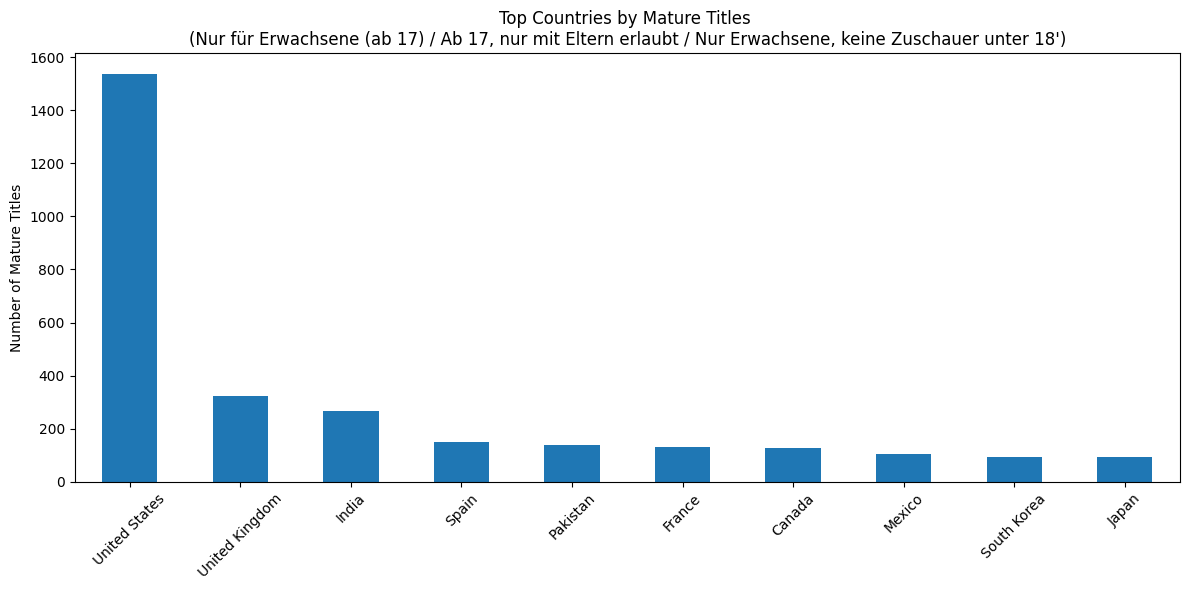

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- Mature-Filter ----
df_mature = df_netflix.query('rating_age >= 17')

# ---- Länder zählen ----
country_counts = (
    df_mature['country_clean']
    .value_counts()
    .head(10)               # Top 10
)

# ---- Plot ----
plt.figure(figsize=(12,6))
country_counts.plot(kind='bar')
plt.title(f"Top Countries by Mature Titles \n({' / '.join(df_mature.rating_description.unique())}')")
plt.xlabel("")
plt.ylabel("Number of Mature Titles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


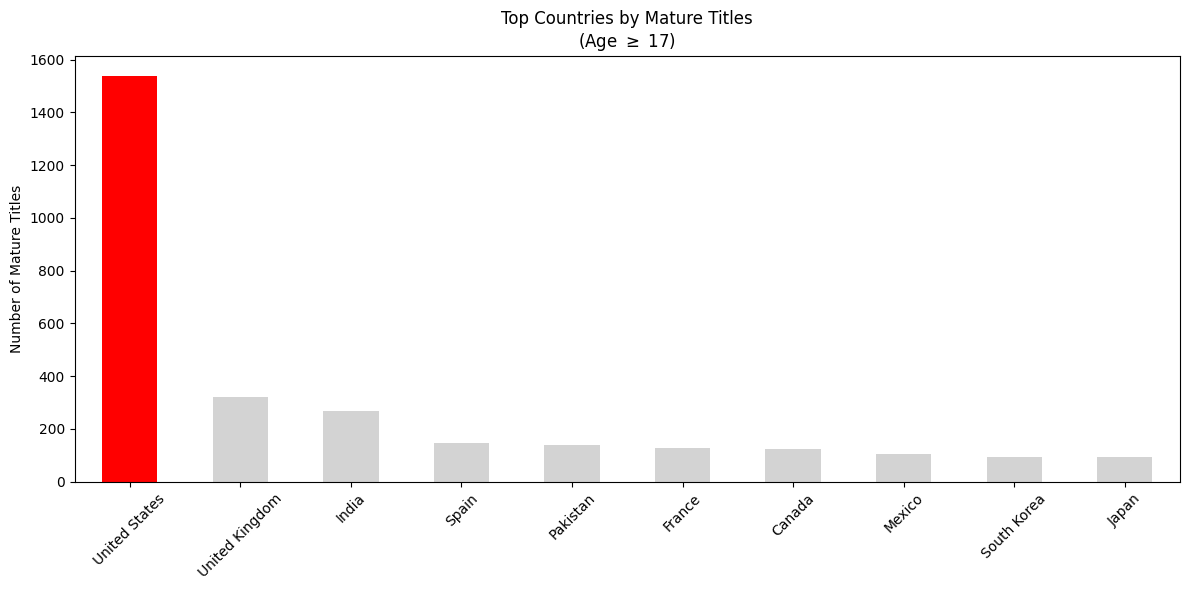

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- Mature-Filter ----
age_filter = 17
df_mature = df_netflix.query('rating_age >= @age_filter')

# ---- Länder zählen ----
country_counts = (
    df_mature['country_clean']
    .value_counts()
    .head(10)  # Top 10
)

# ---- Farben definieren ----
colors = ['red'] + ['lightgrey'] * (len(country_counts) - 1)

# ---- Plot ----
plt.figure(figsize=(12, 6))
country_counts.plot(kind='bar', color=colors)

plt.title(
    f"Top Countries by Mature Titles\n"
    fr"(Age $\geq$ {age_filter})"
)

plt.xlabel("")
plt.ylabel("Number of Mature Titles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Design
- United States rot, rest grau
- Kategorie als Age>=17 abkürzen im Titel
- top x Coutnries als Zahl
- von wievieln Coutnries total

## Story
- Faden überlegen, wie Chart1 (ist effektiv ein Shift passiert? Ja) -> Chart4 (Einfluss pro Land auf Netflix) verknüpft werden kann
- USA hat Netflix contentmässig auf jeden Fall sehr stark beeinflusst im Bereich Mature-Content.
- Hypothese1: Gibt es in USA Ängste von Klagen je nach COntent oder sind USA einfach generell prüder?

In [100]:
import plotly.express as px

# Datensatz filtern
min_age = 17
df_mature = df_netflix.query('rating_age >= @min_age')
df_mature_exp = df_mature.explode('genres_list')

# Nur gültige Einträge
df_mature_exp = df_mature_exp.dropna(subset=["country", "genres_list"])

# Top-Land bestimmen
country_counts = df_mature_exp['country'].value_counts()
top_country = country_counts.index[0]
total_titles = country_counts.sum()

# Anteil berechnen
country_percent = (country_counts / total_titles * 100).round(1)

# Optional: neues Label mit Anteil erstellen
df_mature_exp['country_label'] = df_mature_exp['country'].apply(
    lambda c: f"{c} ({country_percent[c]}%)" if c in country_percent else c
)

# Farbdict erstellen
color_map = {c: "rgb(220,0,0)" if c == top_country else "rgb(180,180,180)"
             for c in df_mature_exp["country"].unique()}

# Treemap
fig = px.treemap(
    df_mature_exp,
    path=["country_label", "genres_list"],  # hier Labels mit Anteil
    color="country",
    color_discrete_map=color_map,
    title=f"Mature Titles Per Country (min. age > {min_age} years old)"
)

fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    height=700
)

fig.show()


### design
- Ggf. mehr Fokus auf etwas, das noch erst in der STory entdeckt wird?

### Story
- Herunterbrechen, damit keine falschen Ideen passieren bezüglich dem Mature-Content (Porn?)
- Es gibt Comedies, die als Mature gelten in den USA, was möglicherweise in Europa lächerlich wäre (verklagungen? Microwave-Hints)


In [84]:
import plotly.express as px

# Datensatz filtern
df_mature = df_netflix.query('rating_age >= 17')
df_mature_exp = df_mature.explode('genres_list')

# Nur gültige Einträge (Genres + Country)
df_mature_exp = df_mature_exp.dropna(subset=["country", "genres_list"])

# Top-Land bestimmen
country_counts = (
    df_mature_exp.groupby("country")
    .size()
    .sort_values(ascending=False)
)

top_country = country_counts.index[0]

# Farbdict erstellen:
color_map = {c: "rgb(220,0,0)" if c == top_country else "rgb(180,180,180)"
             for c in df_mature_exp["country"].unique()}

# Treemap
fig = px.treemap(
    df_mature_exp,
    path=["country", "genres_list"],
    color="country",                 # <-- WICHTIG
    color_discrete_map=color_map,   # <-- garantiert deine Farben
    title="Treemap: Mature Titles → Country → Genre"
)

fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    height=700
)

fig.show()


In [83]:
import plotly.express as px

# Definde Dataframe
df_mature = df_netflix.query('rating_age >= 17')
df_mature_exp = df_mature.explode('genres_list')

# Set colors
country_counts = (
    df_mature_exp.groupby("country_clean")
    .size()
    .sort_values(ascending=False)
)

top_country = country_counts.index[0]

# Farbdict erstellen:
color_map = {c: "rgb(220,0,0)" if c == top_country else "rgb(180,180,180)"
             for c in df_mature_exp["country"].unique()}

# Treemap Country → Genre
fig = px.treemap(
    df_mature_exp,
    path=["country", "genres_list"],
    color_discrete_map=color_map,
    title="Treemap: Mature Titles → Country → Genre"
)

fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    height=700
)

fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# -------- 1. Mature filter --------
mature_ratings = ["TV-MA", "R", "NC-17", "18+", "Adults Only"]
df_mature = df[df["rating"].isin(mature_ratings)]

# -------- 2. Länder sauber expandieren --------
df_exploded = (
    df_mature.assign(country_clean=df_mature["country_clean"].str.split(", "))
    .explode("country_clean")
)

# -------- 3. Counts vorbereiten --------
country_counts = (
    df_exploded["country_clean"]
    .value_counts()
    .reset_index()
)

country_counts.columns = ["country", "mature_count"]

# -------- 4. Treemap --------
fig = px.treemap(
    country_counts,
    path=["country"],
    values="mature_count",
    title="Mature Titles by Country (Treemap: TV-MA / R / NC-17)",
)

fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    height=600
)

fig.show()


## Stacked Adult movies per country

In [ ]:
import pandas as pd
import plotly.express as px

# Mature Titles filtern
mature_ratings = ["TV-MA", "R", "NC-17", "18+", "Adults Only"]
df_mature = df_netflix[df_netflix['rating'].isin(mature_ratings)].copy()

# Länder + Jahre aufbereiten
df_mature = df_mature.dropna(subset=['country', 'release_year'])


# Explode Länder, falls mehrere pro Titel
df_mature_exp = df_mature.assign(
    country=df_mature['country'].str.split(", ")
).explode('country')

df_mature_exp['country'] = df_mature_exp['country'].str.strip()

# Optional: Top 5 Länder + Rest als "Other"
top_countries = df_mature_exp['country'].value_counts().head(10000).index.tolist()
df_mature_exp['country_grouped'] = df_mature_exp['country'].apply(
    lambda x: x if x in top_countries else 'Other'
)

df_counts = df_mature_exp.groupby(
    ['release_year', 'country_grouped']
).size().reset_index(name='count')
# 1. sortieren
df_counts = df_counts.sort_values('release_year')

# 2. release_year als ordered categorical
years_sorted = sorted(df_counts['release_year'].unique())
df_counts['release_year'] = pd.Categorical(df_counts['release_year'],
                                           categories=years_sorted,
                                           ordered=True)



fig = px.bar(
    df_counts,
    x='release_year',
    y='count',
    color='country_grouped',
    title='Mature Titles by Country over Years',
    labels={'count':'Number of Mature Titles', 'release_year':'Release Year'},
)

# Stacked
fig.update_layout(barmode='stack',
                #  xaxis={'type':'category'},
                  height=600)
fig.show()


- Pandemic drop in the industry?
- Auch wenn der dominante US-Anteil von 2013 bis 2020 stetig anwuchs....

In [181]:
import pandas as pd
import plotly.express as px

# Mature Titles filtern
mature_ratings = ["TV-MA", "R", "NC-17", "18+", "Adults Only"]
df_mature = df_netflix[df_netflix['rating'].isin(mature_ratings)].copy()

# Länder + Jahre aufbereiten
df_mature = df_mature.dropna(subset=['country', 'release_year'])

# Explode Länder, falls mehrere pro Titel
df_mature_exp = df_mature.assign(
    country=df_mature['country'].str.split(", ")
).explode('country')

df_mature_exp['country'] = df_mature_exp['country'].str.strip()

# Optional: Top N Länder + Rest als "Other"
top_countries = df_mature_exp['country'].value_counts().head(1).index.tolist()
df_mature_exp['country_grouped'] = df_mature_exp['country'].apply(
    lambda x: x if x in top_countries else 'Other'
)

# Counts pro Year + Country
df_counts = df_mature_exp.groupby(
    ['release_year', 'country_grouped']
).size().reset_index(name='count')

# Anteil pro Jahr berechnen
df_counts['total_per_year'] = df_counts.groupby('release_year')['count'].transform('sum')
df_counts['relative_count'] = df_counts['count'] / df_counts['total_per_year']

# release_year sortieren
years_sorted = sorted(df_counts['release_year'].unique())
df_counts['release_year'] = pd.Categorical(df_counts['release_year'],
                                           categories=years_sorted,
                                           ordered=True)

# Plot
fig = px.bar(
    df_counts,
    x='release_year',
    y='relative_count',  # jetzt relative Werte
    color='country_grouped',
    title='Relative Distribution of Mature Titles by Country over Years',
    labels={'relative_count':'Share of Mature Titles', 'release_year':'Release Year'},
)

fig.update_layout(barmode='stack', height=600, yaxis=dict(tickformat='.0%'))
fig.show()


- wird dieser US-dominierte Anteil langsam aber stetig verdrängt.

## Alluvial / Sankey

<Axes: xlabel='rating_age', ylabel='duration_minutes'>

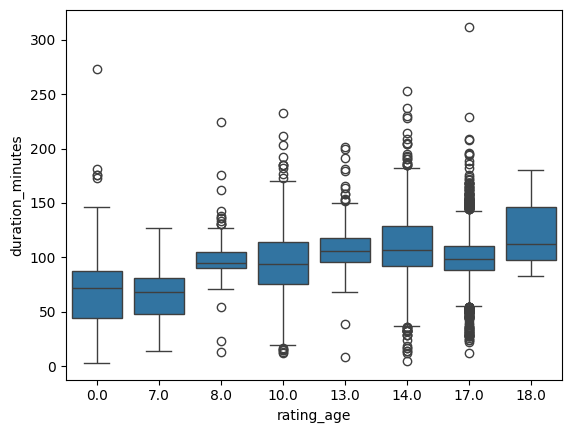

In [113]:
import seaborn as sns
df_duration = df_netflix[['type', 'duration_minutes', 'rating_age']].dropna()
sns.boxplot(data=df_duration,x='rating_age',y='duration_minutes')

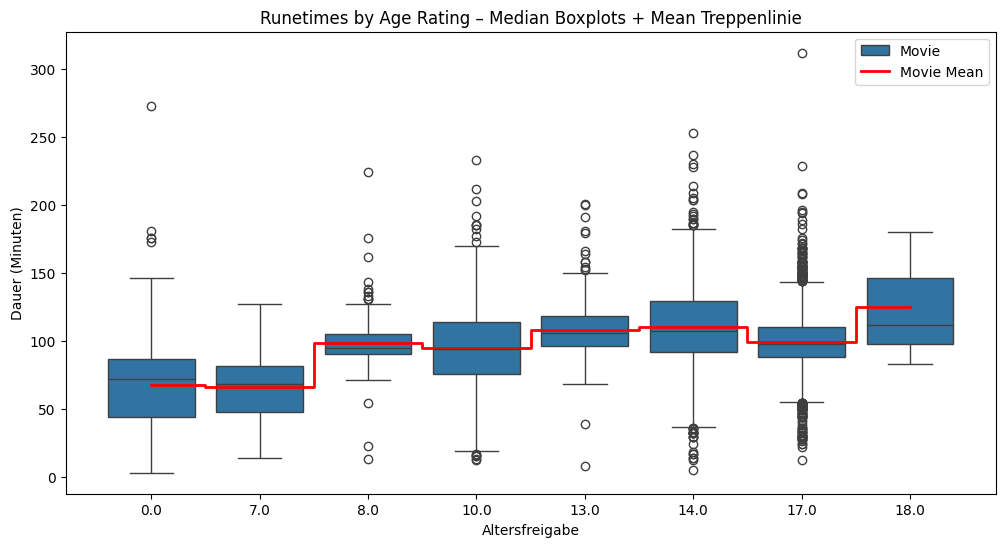

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# x-Achse sortieren
order = sorted(df_duration['rating_age'].unique())

plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_duration,
    x='rating_age',
    y='duration_minutes',
    hue='type',
    order=order,
    showfliers=True
)

# Mean pro Alterskategorie berechnen
mean_values = df_duration.groupby(['rating_age','type'])['duration_minutes'].mean().reset_index()

# Treppenlinie einzeichnen
for t in df_duration['type'].unique():
    subset = mean_values[mean_values['type'] == t]
    plt.step(
        x=[order.index(r) for r in subset['rating_age']],  # x als Positionsindex
        y=subset['duration_minutes'],
        where='mid',  # Treppenform
        label=f'{t} Mean',
        linewidth=2,
        color='red'
    )

plt.ylabel('Dauer (Minuten)')
plt.xlabel('Altersfreigabe')
plt.title('Runetimes by Age Rating – Median Boxplots + Mean Treppenlinie')
plt.legend()
plt.show()


<Axes: xlabel='rating_age', ylabel='duration_minutes'>

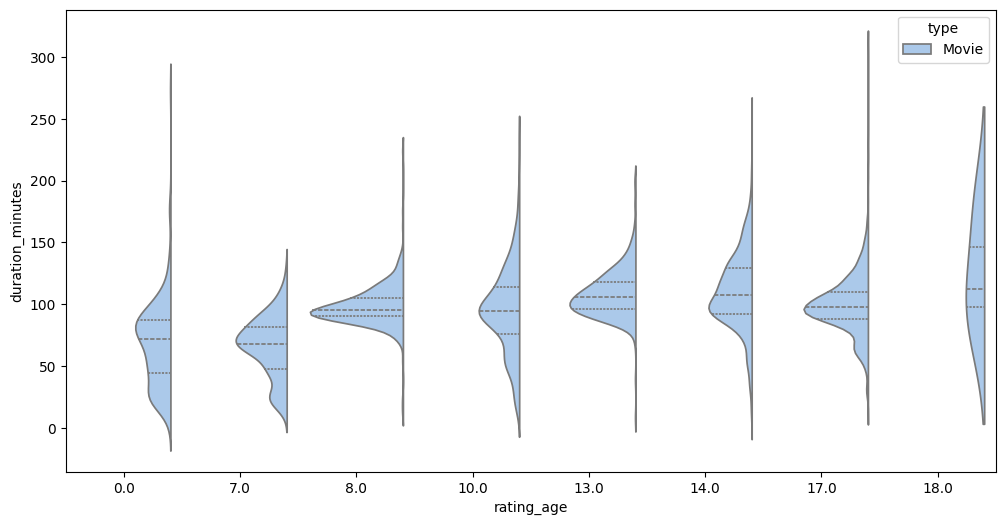

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Altersgruppen definieren
def age_group(r):
    if r <= 7:
        return 'Children'
    elif r <= 16:
        return 'Teenagers'
    else:
        return 'Adults'

df_duration['age_group'] = df_duration['rating_age'].apply(age_group)

plt.figure(figsize=(12,6))

# Violinplot
sns.violinplot(
    data=df_duration,
    x='rating_age',
    y='duration_minutes',
    hue='type',
    split=True,          # Movies & TV Shows innerhalb derselben Violine
    inner='quartile',    # zeigt Median & Quartile
    palette='pastel'
)

# Optional: log-Skala, falls Extremwerte die Darstellung verzerren
# plt.yscale('l


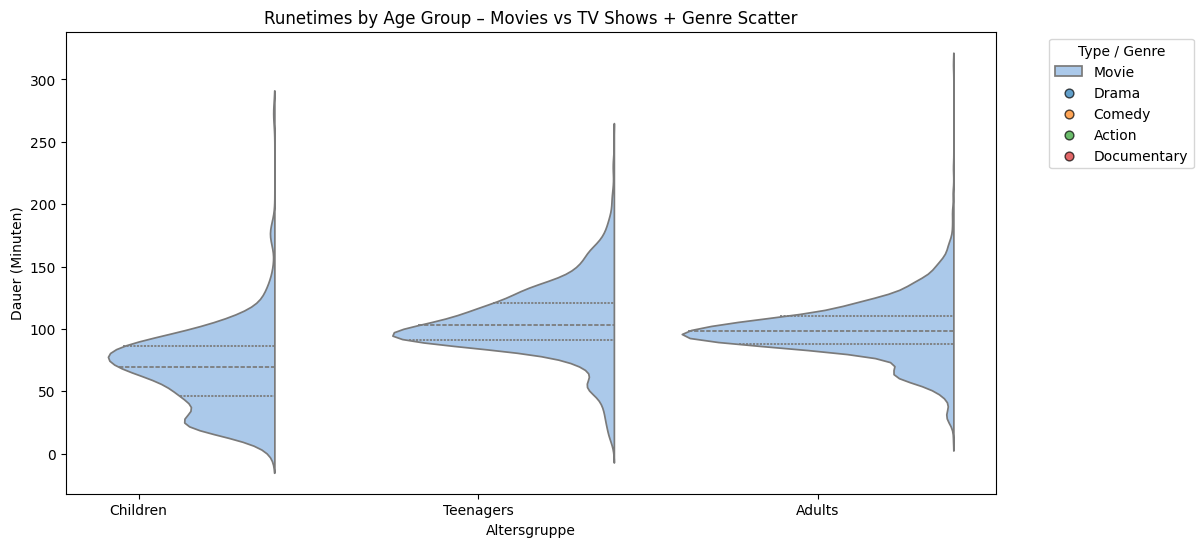

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

df_plot = df_netflix[['type', 'duration_minutes', 'rating_age', 'genres_list']].dropna()

# Altersgruppen
def age_group(r):
    if r <= 7: return 'Children'
    elif r <= 16: return 'Teenagers'
    else: return 'Adults'

df_plot['age_group'] = df_plot['rating_age'].apply(age_group)
age_order = ['Children','Teenagers','Adults']

plt.figure(figsize=(12,6))

# Violinplot
ax = sns.violinplot(
    data=df_plot,
    x='age_group',
    y='duration_minutes',
    hue='type',
    split=True,
    inner='quartile',
    palette='pastel',
    order=age_order
)

# Scatter nach Genre
main_genres = ['Drama', 'Comedy', 'Action', 'Documentary']
df_scatter = df_plot[df_plot['genres_list'].isin(main_genres)]
genre_palette = sns.color_palette('tab10', n_colors=len(main_genres))
genre_color_map = dict(zip(main_genres, genre_palette))

# Berechne x-Offsets pro Type (wie Seaborn sie splitet)
# Movies links (-0.15), TV Shows rechts (+0.15)
type_offset = {'Movie': -0.15, 'TV Show': 0.15}

scatter_handles = []
scatter_labels = []

for genre in main_genres:
    subset = df_scatter[df_scatter['genres_list'] == genre]
    x_pos = []
    for _, row in subset.iterrows():
        idx = age_order.index(row['age_group'])
        offset = type_offset.get(row['type'], 0)  # falls andere Type
        x_pos.append(idx + offset + 0.05*(np.random.rand()-0.5))  # leichter jitter
    sc = plt.scatter(x=x_pos, y=subset['duration_minutes'],
                     color=genre_color_map[genre],
                     alpha=0.7, edgecolor='k', s=40)
    scatter_handles.append(sc)
    scatter_labels.append(genre)

# Violinplot-Legende
handles_violin, labels_violin = ax.get_legend_handles_labels()

plt.legend(handles=handles_violin + scatter_handles, labels=labels_violin + scatter_labels,
           title='Type / Genre', bbox_to_anchor=(1.05,1), loc='upper left')

plt.ylabel('Dauer (Minuten)')
plt.xlabel('Altersgruppe')
plt.title('Runetimes by Age Group – Movies vs TV Shows + Genre Scatter')
plt.show()


['International Movies', 'Dramas', 'Comedies', 'Action & Adventure', 'Documentaries']


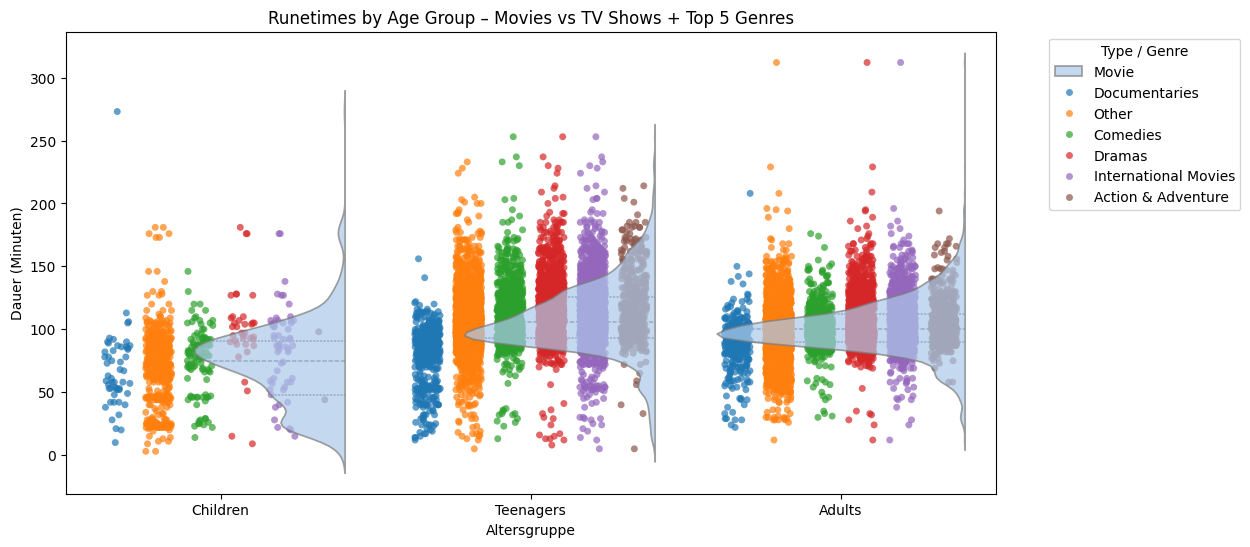

In [175]:
# Explodierte Genres bereits in df_plot
top_genres = df_plot['genres_list'].value_counts().head(5).index.tolist()
print(top_genres)
df_strip = df_plot.copy()
df_strip['genre_for_plot'] = df_strip['genres_list'].apply(lambda x: x if x in top_genres else 'Other')
plt.figure(figsize=(12,6))
ax = plt.gca()

# Violinplot: Verteilung nach Altersgruppe + Type
sns.violinplot(
    data=df_plot,
    x='age_group',
    y='duration_minutes',
    hue='type',
    palette='pastel',
    order=age_order,
    inner='quartile',
    ax=ax,
    zorder=100,
    alpha=0.7,
    split=True
)

# Stripplot: Top 5 + Other
palette = sns.color_palette('tab10', n_colors=6)  # 5 Top + 1 Other
sns.stripplot(
    data=df_strip,
    x='age_group',
    y='duration_minutes',
    hue='genre_for_plot',
    dodge=True,      # besser bei vielen Genres
    jitter=0.25,
    palette=palette,
    size=5,
    alpha=0.7,
    ax=ax
)

# Legende bereinigen (zusammenführen)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Type / Genre', bbox_to_anchor=(1.05,1), loc='upper left')

plt.ylabel('Dauer (Minuten)')
plt.xlabel('Altersgruppe')
plt.title('Runetimes by Age Group – Movies vs TV Shows + Top 5 Genres')
plt.show()


Story
- genres sind sehr ähnlich, dichtde bleibt gliehc.

# Misc trial plots

Kruskal-Wallis (rating vs release_year): H=1153.79, p=0.0000


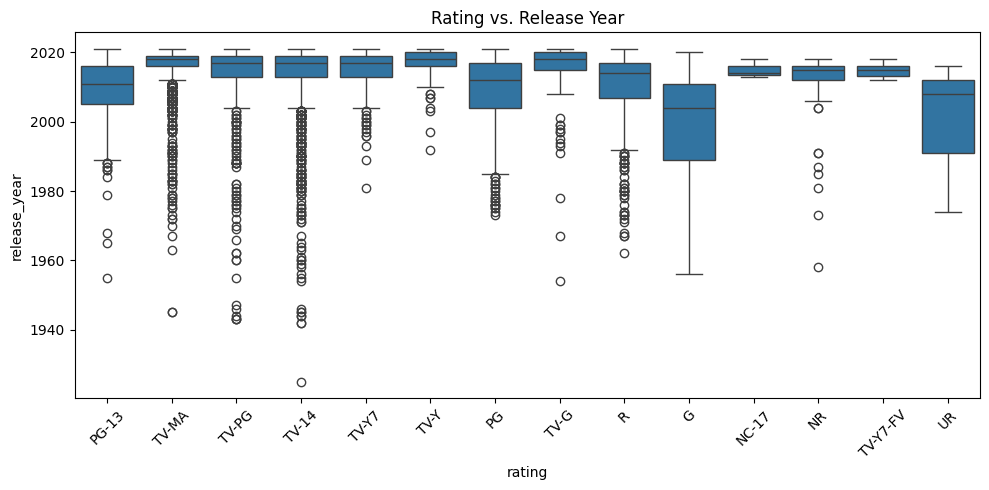

Kruskal-Wallis (rating vs duration): H=1428.93, p=0.0000


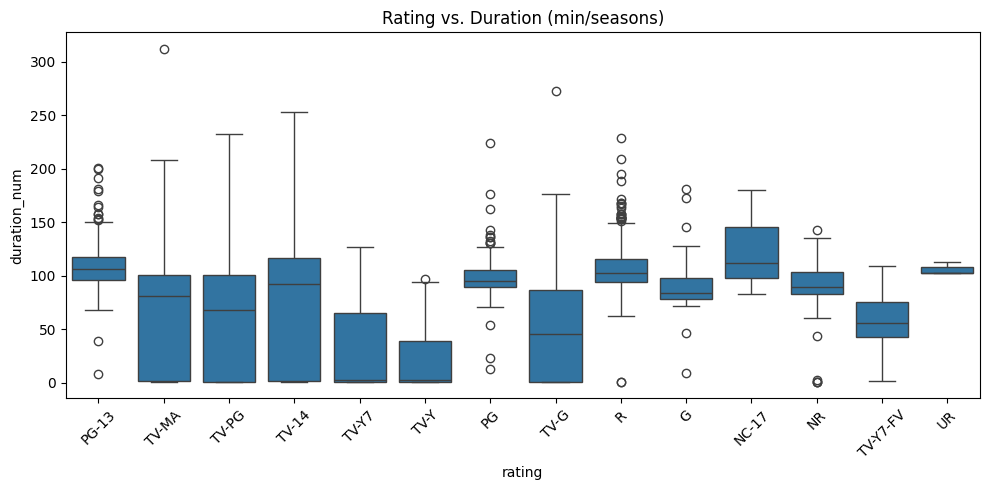

Chi²-Test (rating vs country): χ²=3641.62, p=0.0000


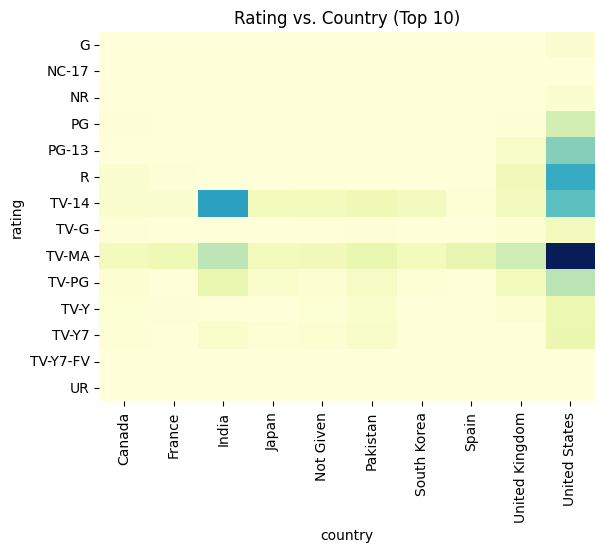

Korrelation (Rating ↔ Genre):
Kids' TV                     0.359725
TV Comedies                  0.125971
British TV Shows             0.082722
Movies                       0.081441
International TV Shows       0.078924
Docuseries                   0.076452
Stand-Up Comedy              0.068702
Crime TV Shows               0.064082
TV Action & Adventure        0.059013
Spanish-Language TV Shows    0.056278
Name: rating_code, dtype: float64


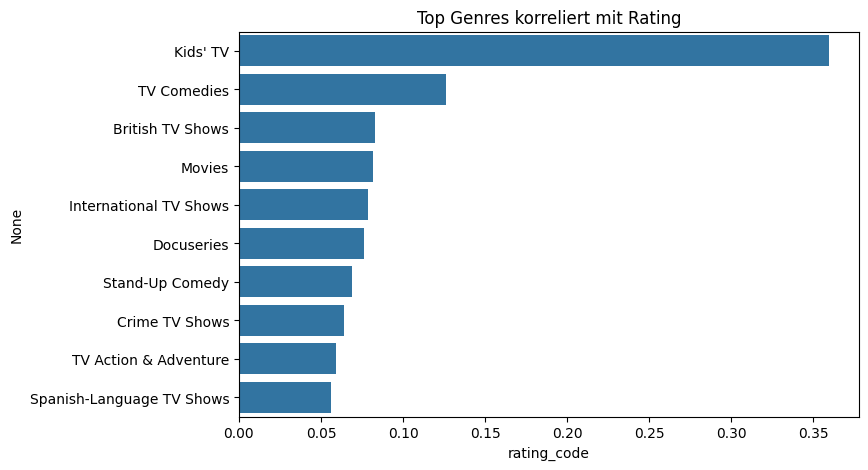

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, chi2_contingency

# Daten
df = df_netflix.copy()

# Cleaning
df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce")
df["duration_num"] = (
    df["duration"]
    .astype(str)
    .str.extract(r"(\d+)")  # nur Zahl
    .astype(float)
)
df["genres_list"] = df["listed_in"].astype(str).str.split(", ")
df = df.dropna(subset=["rating"])

# --- Rating vs Release Year ---
df_yr = df.dropna(subset=["release_year"])
stat, p_year = kruskal(
    *[group["release_year"].values for _, group in df_yr.groupby("rating")]
)
print(f"Kruskal-Wallis (rating vs release_year): H={stat:.2f}, p={p_year:.4f}")

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_yr, x="rating", y="release_year")
plt.title("Rating vs. Release Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Rating vs Duration ---
df_dur = df.dropna(subset=["duration_num"])
stat, p_dur = kruskal(
    *[group["duration_num"].values for _, group in df_dur.groupby("rating")]
)
print(f"Kruskal-Wallis (rating vs duration): H={stat:.2f}, p={p_dur:.4f}")

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_dur, x="rating", y="duration_num")
plt.title("Rating vs. Duration (min/seasons)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Rating vs Country ---
ct_country = pd.crosstab(df["rating"], df["country"])
chi2_country, p_country, _, _ = chi2_contingency(ct_country)
print(f"Chi²-Test (rating vs country): χ²={chi2_country:.2f}, p={p_country:.4f}")

# Heatmap der größten Länder
top_countries = df["country"].value_counts().nlargest(10).index
sns.heatmap(
    pd.crosstab(df[df["country"].isin(top_countries)]["rating"],
                df["country"]),
    cmap="YlGnBu",
    cbar=False
)
plt.title("Rating vs. Country (Top 10)")
plt.show()

# --- Rating vs Genre ---
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(
    mlb.fit_transform(df["genres_list"]),
    columns=mlb.classes_,
    index=df.index
)

genre_corr = pd.concat([df["rating"], genres_encoded], axis=1)
# Umwandeln Rating in numerische Codes
genre_corr["rating_code"] = genre_corr["rating"].astype("category").cat.codes
corrs = genre_corr.corr(numeric_only=True)["rating_code"].drop("rating_code").sort_values(ascending=False)

print("Korrelation (Rating ↔ Genre):")
print(corrs.head(10))

plt.figure(figsize=(8,5))
sns.barplot(x=corrs.head(10), y=corrs.head(10).index)
plt.title("Top Genres korreliert mit Rating")
plt.show()


/tmp/ipykernel_71696/3902742338.py:29: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



→ 539 Titel nach Sampling pro Jahr


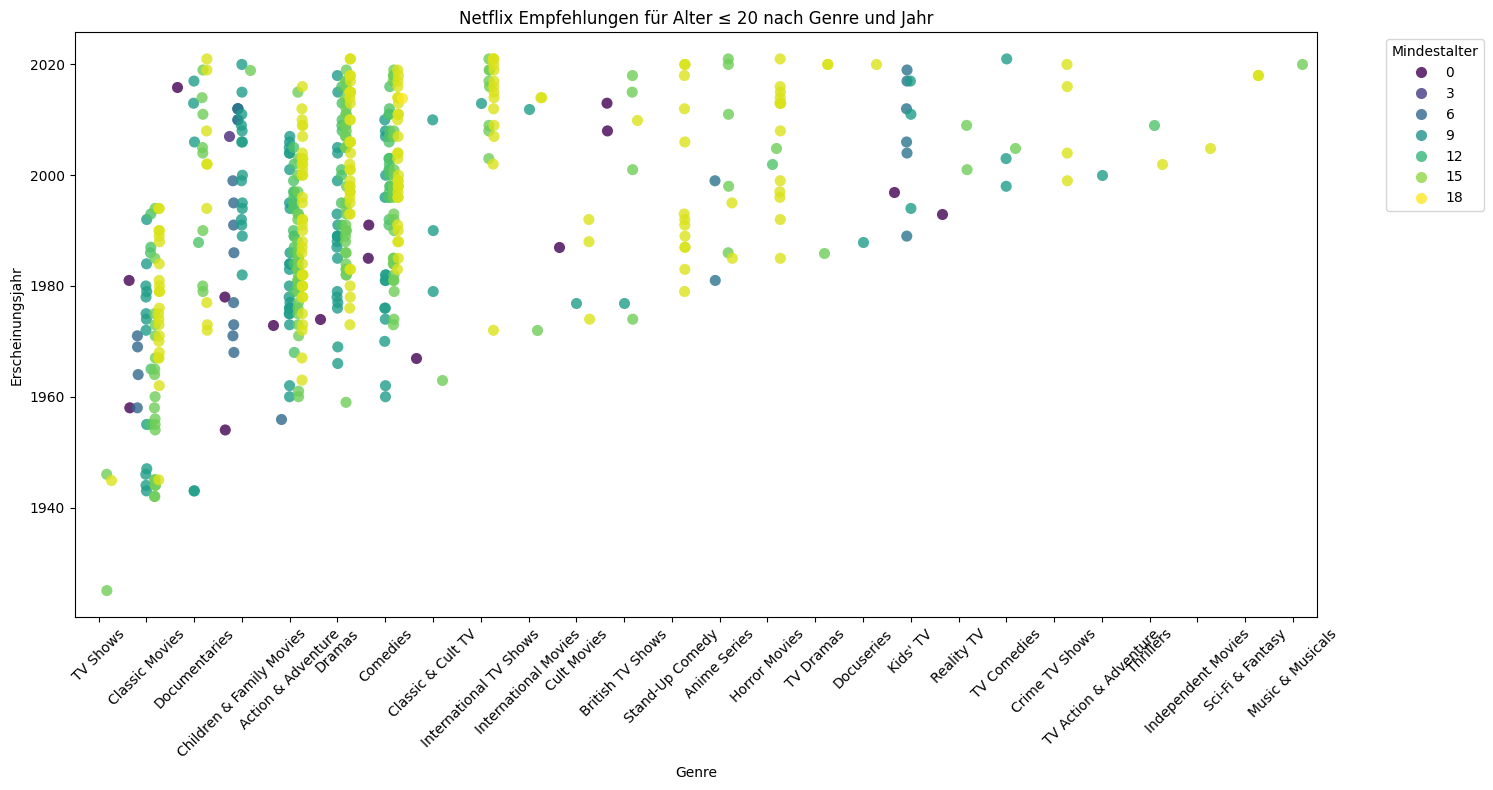

In [39]:
import pandas as pd
import numpy as np
import plotly.express as px

df = df_netflix.copy()

# Ratings säubern & Mindestalter zuweisen
df["rating"] = df["rating"].astype(str).str.strip().fillna("NR")
rating_age_map = {
    "TV-Y": 2, "TV-Y7": 7, "TV-Y7-FV": 7, "G": 6, "PG": 10, "PG-13": 13,
    "TV-PG": 10, "TV-14": 14, "TV-MA": 17, "R": 17, "NC-17": 18, "NR": 0, "UR": 0
}
df["min_age"] = df["rating"].map(lambda r: rating_age_map.get(r, 0))
df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce")

# Hauptgenre extrahieren
df["main_genre"] = df["listed_in"].astype(str).str.split(",").str[0].str.strip()

age = 20
top_n_per_year = 10

# Filter für Alter
subset = df[(df["min_age"].notna()) & (df["min_age"] <= age)].copy()

# Pro Jahr maximal top_n_per_year zufällig auswählen
def sample_per_year(group, n=10):
    return group.sample(min(len(group), n), random_state=42)

subset_sampled = subset.groupby("release_year").apply(sample_per_year, n=top_n_per_year).reset_index(drop=True)

print(f"→ {len(subset_sampled)} Titel nach Sampling pro Jahr")

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))

sns.stripplot(
    data=subset_sampled,
    x="main_genre",
    y="release_year",
    hue="min_age",
    jitter=True,        # kleine horizontale Verschiebung, damit Punkte sichtbar bleiben
    dodge=True,         # Farbgruppen leicht verschieben
    palette="viridis",
    size=8,
    alpha=0.8
)

plt.xlabel("Genre")
plt.ylabel("Erscheinungsjahr")
plt.title(f"Netflix Empfehlungen für Alter ≤ {age} nach Genre und Jahr")
plt.xticks(rotation=45)
plt.legend(title="Mindestalter", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import plotly.express as px

df = df_netflix.copy()

# --- Genres vorbereiten ---
df["genres_list"] = df["listed_in"].astype(str).str.split(", ")
df_exploded = df.explode("genres_list")

# --- Optional: nur Top 20 Genres und Länder für bessere Übersicht ---
top_genres = df_exploded["genres_list"].value_counts().nlargest(10000).index
top_countries = df_exploded["country"].value_counts().nlargest(20).index

df_exploded = df_exploded[df_exploded["genres_list"].isin(top_genres) & df_exploded["country"].isin(top_countries)]

# --- Pivot für Heatmap ---
heatmap_data = df_exploded.groupby(["country","genres_list"]).size().reset_index(name="count")
heatmap_pivot = heatmap_data.pivot(index="country", columns="genres_list", values="count").fillna(0)

# --- Heatmap plotten ---
fig = px.imshow(
    heatmap_pivot,
    labels=dict(x="Genre", y="Land", color="Anzahl Filme"),
    x=heatmap_pivot.columns,
    y=heatmap_pivot.index,
    color_continuous_scale="Viridis",
    text_auto=True
)

fig.update_layout(title="Netflix: Anzahl Filme pro Land vs Genre", xaxis_tickangle=-45)
fig.show()


In [11]:
df_exploded.genres_list.unique()

array(['Documentaries', 'Crime TV Shows', 'International TV Shows',
       'TV Action & Adventure', 'TV Dramas', 'TV Horror', 'TV Mysteries',
       'Children & Family Movies', 'Comedies', 'Dramas',
       'Independent Movies', 'International Movies', 'British TV Shows',
       'Reality TV', 'Music & Musicals', 'Movies', 'Docuseries',
       "Kids' TV", 'Romantic Movies', 'Horror Movies', 'Sci-Fi & Fantasy',
       'Thrillers', 'Spanish-Language TV Shows', 'TV Comedies',
       'TV Thrillers', 'Anime Series', 'Korean TV Shows',
       'Romantic TV Shows', 'Action & Adventure', 'Classic Movies',
       'Anime Features', 'Teen TV Shows', 'Stand-Up Comedy & Talk Shows',
       'Sports Movies', 'Science & Nature TV', 'Cult Movies',
       'Stand-Up Comedy', 'Faith & Spirituality', 'LGBTQ Movies',
       'TV Sci-Fi & Fantasy', 'TV Shows', 'Classic & Cult TV'],
      dtype=object)

In [5]:
df_netflix.country.unique()

array(['United States', 'France', 'Brazil', 'United Kingdom', 'India',
       'Germany', 'Pakistan', 'Not Given', 'China', 'South Africa',
       'Japan', 'Nigeria', 'Spain', 'Philippines', 'Australia',
       'Argentina', 'Canada', 'Hong Kong', 'Italy', 'New Zealand',
       'Egypt', 'Colombia', 'Mexico', 'Belgium', 'Switzerland', 'Taiwan',
       'Bulgaria', 'Poland', 'South Korea', 'Saudi Arabia', 'Thailand',
       'Indonesia', 'Kuwait', 'Malaysia', 'Vietnam', 'Lebanon', 'Romania',
       'Syria', 'United Arab Emirates', 'Sweden', 'Mauritius', 'Austria',
       'Turkey', 'Czech Republic', 'Cameroon', 'Netherlands', 'Ireland',
       'Russia', 'Kenya', 'Chile', 'Uruguay', 'Bangladesh', 'Portugal',
       'Hungary', 'Norway', 'Singapore', 'Iceland', 'Serbia', 'Namibia',
       'Peru', 'Mozambique', 'Ghana', 'Zimbabwe', 'Israel', 'Finland',
       'Denmark', 'Paraguay', 'Cambodia', 'Georgia', 'Soviet Union',
       'Greece', 'West Germany', 'Iran', 'Venezuela', 'Slovenia',
       'Gua